# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from unidecode import unidecode
import nltk
from nltk.util import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from itertools import combinations
from matplotlib.ticker import MaxNLocator
from IPython.display import display, Markdown

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leomurta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/leomurta/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Dataset preprocessing

In [2]:
def first_last(text):
    words = text.strip().split(' ')
    return f'{words[0]} {words[-1]}'

# reads publications from Excel file
df = pd.read_excel('publications.xlsx', keep_default_na=False)

# Trnasforms the string of authores into a list of authors without accents and with just furst and last name
df['authors'] = df['authors']\
    .apply(unidecode)\
    .str.strip()\
    .str.split('; ')\
    .apply(lambda x: [first_last(author) for author in x])

# Transforms the string of institutions into a list of institutions without accents
df['institutions'] = df['institutions']\
    .apply(unidecode)\
    .str.strip()\
    .str.split('; ')

df

,title,authors,institutions,venue,year,citations
0,Towards Component-based Software Maintenance v...,"[Leonardo Murta, Hamilton Oliveira, Cristine D...",[UFRJ],wmswm,2004,13
1,Documentacao Essencial para Manutencao de Soft...,"[Sergio Souza, Wesley Neves, Nicolas Anquetil,...",[UCB],wmswm,2004,8
2,Evolução Orientada a Aspectos de um Framework OO,"[Maria Silva, Rosana Braga, Paulo Masiero]",[USP],wmswm,2004,4
3,An Evolution Process for Application Frameworks,"[Maria Cagnin, Jose Maldonado, Paulo Masiero, ...","[USP, UFSCar]",wmswm,2004,6
4,Uma experiencia no ensino de manutencao de sof...,[Marcio Dias],[UNIGOIAS],wmswm,2004,6
...,...,...,...,...,...,...
226,Entendendo o engajamento das comunidades front...,"[Altino Junior, Leticia Meireles, Lucas Figuei...",[PUC Minas],vem,2022,0
227,Exploring Pull Requests in Code Samples,"[Matheus Melo, Gabriel Menezes, Bruno Cafeo]",[UFMS],vem,2022,0
228,Merge Nature: a tool to support research about...,"[Luan Ciribelli, Joao Lima, Heleno Junior, Gle...","[UFJF, UFF, UC Irvine, UNIRIO]",vem,2022,0
229,Perceptions and Difficulties of Software Engin...,"[Humberto Damasceno, Joao Nascimento, Carla Be...",[UFC],vem,2022,0


# Top 20 authors 

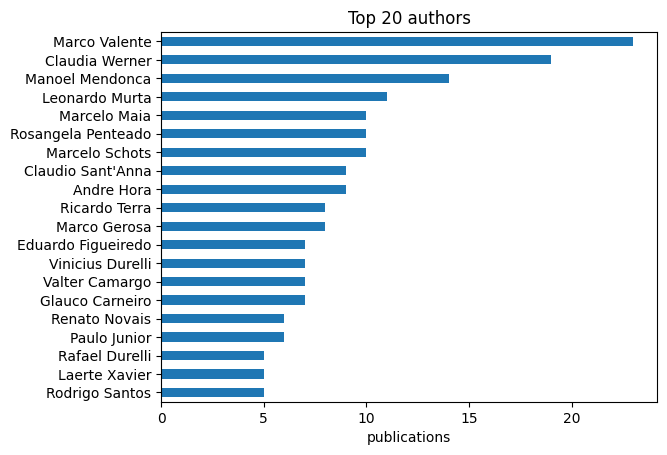

In [3]:
df_authors = df[['authors', 'year']].explode('authors')
top_authors = df_authors['authors'].value_counts().head(20)
top_authors.plot(kind='barh', title='Top 20 authors', xlabel='publications').invert_yaxis()

# Top 3 authors over time

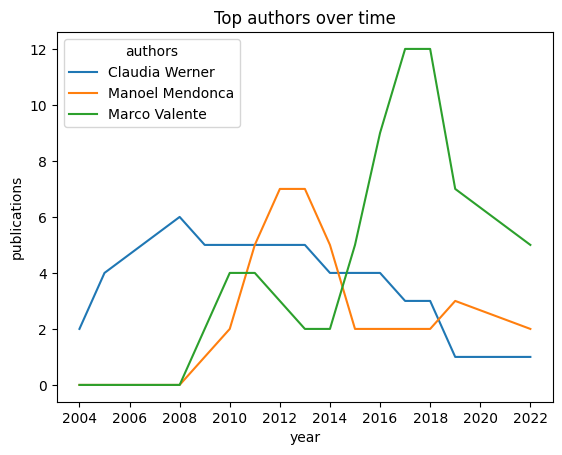

In [4]:
SLIDING_WINDOW_SIZE = 3

df_authors[df_authors['authors'].isin(list(top_authors.head(3).keys()))] \
    .groupby(['authors', 'year'], as_index=False).size() \
    .pivot_table(index='year', columns='authors', values='size', fill_value=0) \
    .rolling(SLIDING_WINDOW_SIZE, min_periods = 0).sum() \
    .plot(kind='line', title='Top authors over time', ylabel='publications') \
    .xaxis.set_major_locator(MaxNLocator(integer=True))

# Authors colaborations

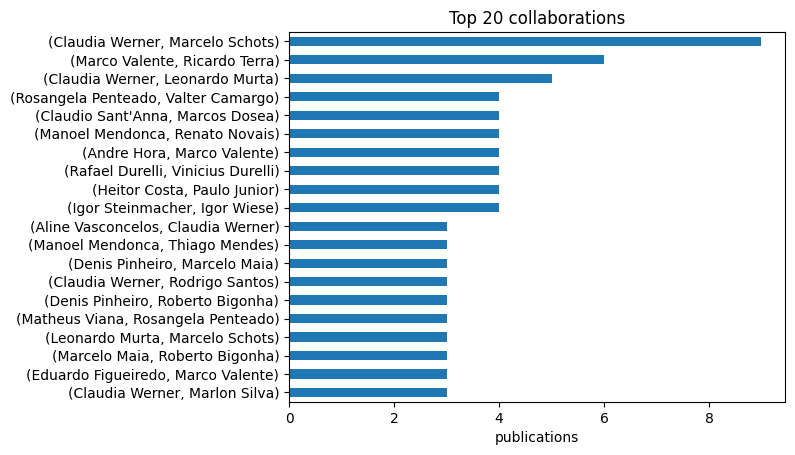

In [5]:
df['authors'].apply(lambda x: list(combinations(sorted(x), 2))).explode().value_counts().head(20) \
    .plot(kind='barh', title='Top 20 collaborations', xlabel='publications') \
    .invert_yaxis()

# Top 20 institutions

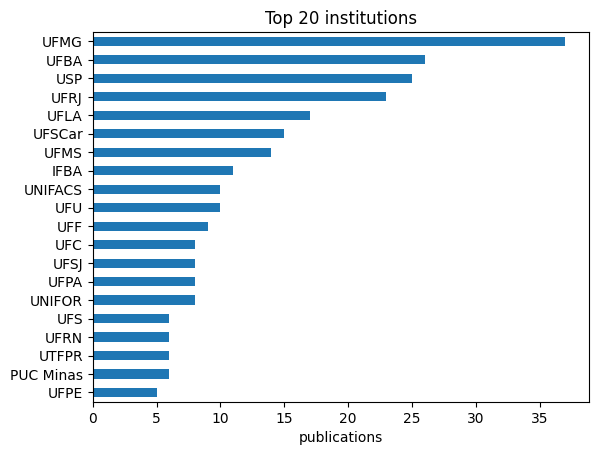

In [6]:
df_institutions = df[['institutions', 'year']].explode('institutions')
top_institutions = df_institutions['institutions'].value_counts().head(20)
top_institutions.plot(kind='barh', title='Top 20 institutions', xlabel='publications').invert_yaxis()

# Institutions collaborations

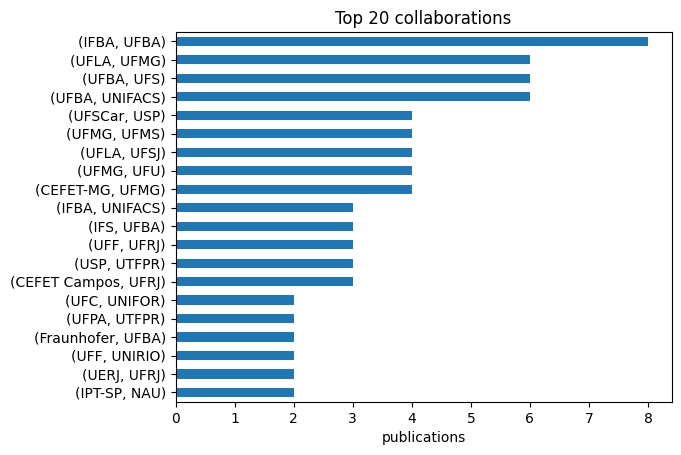

In [7]:
df['institutions'].apply(lambda x: list(combinations(sorted(x), 2))).explode().value_counts().head(20) \
    .plot(kind='barh', title='Top 20 collaborations', xlabel='publications') \
    .invert_yaxis()

# Top 20 bigrams

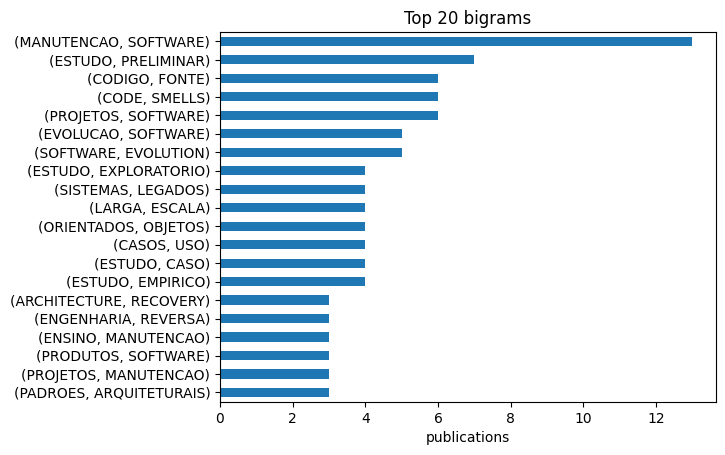

In [8]:
# Removes case, accents, stop words, and tokenizes the titles 
# @TODO: normalize the language
# @TODO: do stemming
df_bigrams = df[['title', 'venue']].copy()
df_bigrams['title'] = df_bigrams['title']\
    .str.upper()\
    .apply(unidecode)\
    .apply(RegexpTokenizer(r'\w+').tokenize)\
    .apply(lambda x: [word for word in x if word.lower() not in (stopwords.words('english') + stopwords.words('portuguese')) + ['sobre', 'atraves']])\
    .apply(lambda x: set(bigrams(x)))
df_bigrams = df_bigrams.explode('title')

top_bigrams = df_bigrams['title'].value_counts().head(20)
top_bigrams.plot(kind='barh', title='Top 20 bigrams', xlabel='publications').invert_yaxis()


# Top 20 bigrams distributed by venue

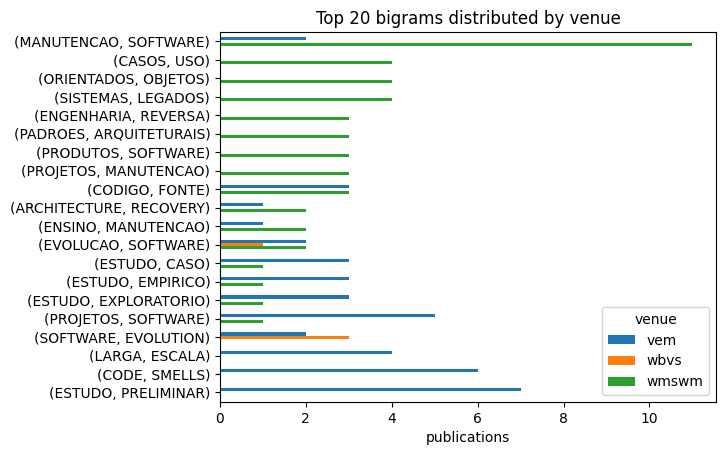

In [9]:
df_bigrams[df_bigrams['title'].isin(list(top_bigrams.head(20).keys()))]\
     .groupby(['title', 'venue'], as_index=False).size()\
     .pivot_table(index='title', columns='venue', values='size', fill_value=0)\
     .sort_values(by=['wmswm','vem'], ascending=[False, True])\
     .plot(kind='barh', title='Top 20 bigrams distributed by venue', xlabel='publications', ylabel='')\
     .invert_yaxis()

# Top h-index most cited cited papers

In [10]:
df_citations = df.sort_values(by='citations', ascending=False).reset_index(drop=True)
display(Markdown(df_citations[df_citations['citations'] >= df_citations.index + 1].to_markdown()))

|    | title                                                                                         | authors                                                                                                                   | institutions              | venue   |   year |   citations |
|---:|:----------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------|:--------------------------|:--------|-------:|------------:|
|  0 | Towards a technique for extracting microservices from monolithic enterprise systems           | ['Alessandra Levcovitz', 'Ricardo Terra', 'Marco Valente']                                                                | ['UFMG', 'UFLA']          | vem     |   2015 |         118 |
|  1 | Microservices in Practice: A Survey Study                                                     | ['Markos Viggiato', 'Ricardo Terra', 'Henrique Rocha', 'Marco Valente', 'Eduardo Figueiredo']                             | ['UFMG', 'UFLA', 'Inria'] | vem     |   2018 |          43 |
|  2 | SkyscrapAR: An Augmented Reality Visualization for Software Evolution                         | ['Rodrigo Souza', 'Bruno Silva', 'Thiago Mendes', 'Manoel Mendonca']                                                      | ['UFBA', 'IFBA']          | wbvs    |   2012 |          24 |
|  3 | Software Architecture Recovery based on Dynamic Analysis                                      | ['Aline Vasconcelos', 'Claudia Werner']                                                                                   | ['UFRJ', 'CEFET Campos']  | wmswm   |   2004 |          19 |
|  4 | Experimental evaluation of code smell detection tools                                         | ['Thanis Paiva', 'Amanda Damasceno', 'Juliana Padilha', 'Eduardo Figueiredo', 'Claudio Sant`Anna']                        | ['UFMG', 'UFBA']          | vem     |   2015 |          18 |
|  5 | Towards an automated approach for bug fix pattern detection                                   | ['Fernanda Madeiral', 'Thomas Durieux', 'Victor Sobreira', 'Marcelo Maia']                                                | ['UFU', 'Inria']          | vem     |   2018 |          14 |
|  6 | Towards Component-based Software Maintenance via Software Configuration Management Techniques | ['Leonardo Murta', 'Hamilton Oliveira', 'Cristine Dantas', 'Luiz Lopes', 'Claudia Werner']                                | ['UFRJ']                  | wmswm   |   2004 |          13 |
|  7 | Evaluation of duplicated code detection tools in cross-project context                        | ['Johnatan Oliveira', 'Eduardo Fernandes', 'Eduardo Figueiredo']                                                          | ['UFMG']                  | vem     |   2015 |          10 |
|  8 | EvolTrack: A Plug-in-Based Infrastructure for Visualizing Software Evolution                  | ['Claudia Werner', 'Leonardo Murta', 'Marcelo Schots', 'Andrea Magdaleno', 'Marlon Silva', 'Rafael Cepeda', 'Caio Vahia'] | ['UFRJ', 'UFF', 'UNIRIO'] | wbvs    |   2011 |           9 |

# Top h5-index most cited papers

In [11]:
df_citations5years = df_citations[df_citations['year'] >= 2017].reset_index(drop=True)
display(Markdown(df_citations5years[df_citations5years['citations'] >= df_citations5years.index + 1].to_markdown()))

|    | title                                                                                                | authors                                                                                       | institutions              | venue   |   year |   citations |
|---:|:-----------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------|:--------------------------|:--------|-------:|------------:|
|  0 | Microservices in Practice: A Survey Study                                                            | ['Markos Viggiato', 'Ricardo Terra', 'Henrique Rocha', 'Marco Valente', 'Eduardo Figueiredo'] | ['UFMG', 'UFLA', 'Inria'] | vem     |   2018 |          43 |
|  1 | Towards an automated approach for bug fix pattern detection                                          | ['Fernanda Madeiral', 'Thomas Durieux', 'Victor Sobreira', 'Marcelo Maia']                    | ['UFU', 'Inria']          | vem     |   2018 |          14 |
|  2 | Who Drive Company-Owned OSS Projects: Employees or Volunteers?                                       | ['Luiz Dias', 'Jhoylan Santos', 'Igor Steinmacher', 'Gustavo Pinto']                          | ['UTFPR', 'UFPA']         | vem     |   2017 |           9 |
|  3 | Do Coupling Metrics Help Characterize Critical Components in Component-based SPL? An Empirical Study | ['Anderson Uchoa', 'Eduardo Fernandes', 'Ana Bibiano', 'Alessandro Garcia']                   | ['PUC-Rio']               | vem     |   2017 |           7 |
|  4 | Monorepos: A Multivocal Literature Review                                                            | ['Gleison Brito', 'Ricardo Terra', 'Marco Valente']                                           | ['UFMG', 'UFLA']          | vem     |   2018 |           6 |